In [88]:
from pathlib import Path
import csv
import matplotlib.pyplot as plt
#try:
#    folder_path = Path("GetData/Rust/get_data_rust/Data/Simulations")
#    reader = csv.DictReader(open(folder_path / "parameters.csv"))
#    par_dict = next(reader) 
#except:
#    raise ValueError("Invalid folder provided")
#sim_num = int(par_dict['Simulatiton Number'])

In [133]:
import tensorflow as tf
import numpy as np
from math import ceil

class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate=0.1):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate

        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.01))
        self.visible_bias = tf.Variable(tf.zeros([num_visible]))
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]))

    def sample_h_given_v(self, v):
        p_h_given_v = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hidden_bias)
        p = tf.random.uniform(shape = p_h_given_v.shape)
        h_new = tf.cast(p_h_given_v <= p, dtype=tf.float32)
        return h_new, p_h_given_v

    def sample_v_given_h(self, h):
        p_v_given_h = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.visible_bias)
        p = tf.random.uniform(shape = p_v_given_h.shape)
        v_new = tf.cast(p_v_given_h <= p, dtype=tf.float32)
        return v_new


    def train(self, input_data, num_epochs=10, batch_size=10):
        num_samples = input_data.shape[0]
        for epoch in range(num_epochs):
            total_loss = 0.0  # Track the total loss for this epoch
            for i in range(0, ceil(num_samples/batch_size), batch_size):
                v0 = input_data[i* batch_size:(i+1) * batch_size]
                h0, h0_prob = self.sample_h_given_v(v0)
                v_new = self.sample_v_given_h(h0)
                h_new, h_new_prob = self.sample_h_given_v(v0)
                self.backward(v0, h0_prob, v_new, h_new_prob)
                reconstruction_loss = tf.reduce_mean(tf.square(v0 - v_new))
                total_loss += reconstruction_loss
            
            if epoch % 25 == 0:
                avg_loss = total_loss / (num_samples / batch_size)
                print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        print("Training completed.")

    def backward(self, v0, h0_prob, v_new, h_new_prob):
        d_vb = np.average(v0, axis=0)-np.average(v_new, axis=0)
        d_hb = np.average(h0_prob, axis=0)-np.average(h_new_prob, axis=0)
        d_W = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v_new), h_new_prob)
        self.W.assign_sub(self.learning_rate * d_W)
        self.hidden_bias.assign_sub(self.learning_rate * d_hb)
        self.visible_bias.assign_sub(self.learning_rate * d_vb)

    def generate(self, num_samples):
        # Gibbs sampling to generate new samples
        samples = tf.random.uniform(shape=[num_samples, self.num_visible])
        for _ in range(1000):  # Perform 1000 Gibbs sampling steps for mixing
            hidden_samples, _ = self.sample_h_given_v(samples)
            samples = self.sample_v_given_h(hidden_samples)
        return samples

In [134]:
import os
import numpy as np
path = "GetData/Rust/get_data_rust/Data/FirstSet/"
data_paths = []
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        if file.endswith(".npy"):
            data_paths.append(os.path.join(root, file))

data_array = []
for file_path in data_paths:
    data_array.append(np.load(file_path).flatten())
data_array = np.array(data_array)

In [138]:
data = tf.convert_to_tensor(data_array, dtype=tf.float32)
rbm = RBM(num_visible=data.shape[1], num_hidden=164, learning_rate=0.01)
rbm.train(data, num_epochs=150, batch_size=100)

Epoch 0/150, Average Loss: 1.4927
Epoch 25/150, Average Loss: 1.0055
Epoch 50/150, Average Loss: 1.0050
Epoch 75/150, Average Loss: 1.0048
Epoch 100/150, Average Loss: 1.0046
Epoch 125/150, Average Loss: 1.0044
Training completed.


In [139]:
data_gen = rbm.generate(10)
data_gen

<tf.Tensor: shape=(10, 4096), dtype=float32, numpy=
array([[1., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.]], dtype=float32)>

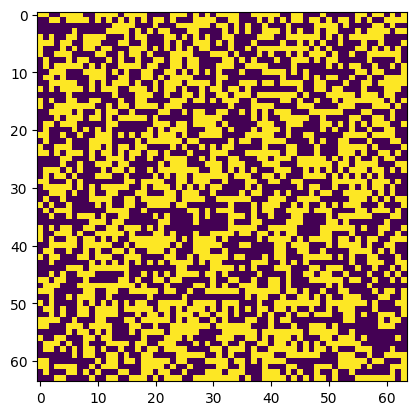

In [144]:
data = tf.reshape(data_gen[0], (64,64))
plt.imshow(data)